In [1]:
import numpy as np
import librosa
import deeplake
from sklearn.decomposition import PCA
import joblib
from sklearn.svm import SVC
from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt

c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
def standardize_mfcc_length(mfcc_list, target_length=100):
    """Standardize MFCC matrices to a fixed length"""
    result = []
    for mfcc in mfcc_list:
        current_length = mfcc.shape[1]
        if current_length > target_length:
            # Truncate if longer than target
            standardized = mfcc[:, :target_length]
        else:
            # Pad with zeros if shorter
            padding = np.zeros((mfcc.shape[0], target_length - current_length))
            standardized = np.hstack([mfcc, padding])
        
        # Flatten the matrix for traditional ML models
        result.append(standardized.flatten())
    
    return np.array(result)

In [3]:
TARGET_LABELS = {"stop", "go", "up", "down", "left", "right"}

def extract_filtered_mfcc_features(dataset, n_mfcc=13, sample_rate=16000):
    """
    Extracts MFCC features only for the selected words.
    
    Parameters:
    - dataset: The Deeplake dataset containing audio tensors.
    - n_mfcc: Number of MFCC coefficients to extract.
    - sample_rate: Target sample rate for librosa processing.
    
    Returns:
    - X: NumPy array of MFCC features (num_samples, n_mfcc)
    - y: NumPy array of corresponding labels
    """
    
    X, y = [], []
    
    for i in range(len(dataset)):
        point_label = dataset.labels[i].data()['text'][0]  

        if point_label in TARGET_LABELS:  # Keep only target samples
            
            audio = dataset['audios'][i].numpy().squeeze()  # Extract audio data
            
            # Compute MFCC
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
            # mfcc_mean = np.mean(mfcc, axis=1)  # second method: Can take mean of factors for more simplistic feature set
            
            X.append(mfcc)
            y.append(point_label)
            
    return standardize_mfcc_length(X), np.array(y)

In [4]:

# Load dataset
dataset = deeplake.load('hub://activeloop/speech-commands-train')

-

Opening dataset in read-only mode as you don't have write permissions.


-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/speech-commands-train



/

hub://activeloop/speech-commands-train loaded successfully.



In [5]:
# Extract features
X, y = extract_filtered_mfcc_features(dataset)

# Scale/ normalize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance dataset out / generate synthetic samples for under-represented classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:713: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(
c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:713: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


In [6]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)


# Define the pipeline
# Define pipeline using kernel SVM
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())  
])

# Define grid search parameters for RBF kernel
param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 0.01, 0.001],  
    "svc__kernel": ["rbf"]  
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy"
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get best model and score
print("Best Params:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)




Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best Accuracy: 0.8516281512605041


In [7]:
# Evaluate model
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")

print("\nSVM Performance:")
print(classification_report(y_test, y_pred))



SVM Accuracy: 0.8827

SVM Performance:
              precision    recall  f1-score   support

        down       0.87      0.87      0.87       476
          go       0.88      0.88      0.88       476
        left       0.87      0.88      0.88       476
       right       0.92      0.91      0.91       476
        stop       0.92      0.89      0.91       476
          up       0.84      0.85      0.84       476

    accuracy                           0.88      2856
   macro avg       0.88      0.88      0.88      2856
weighted avg       0.88      0.88      0.88      2856



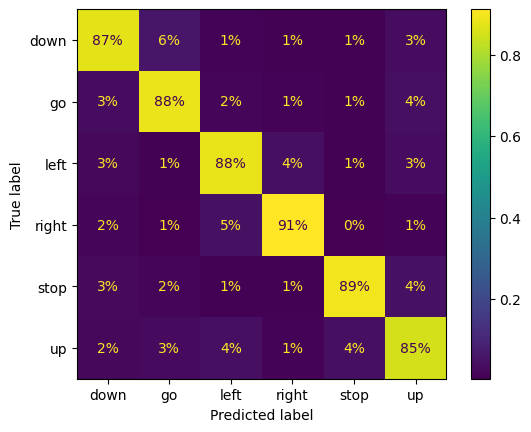

In [8]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        normalize="true", values_format=".0%")
plt.show()

In [9]:

# Save
joblib.dump(grid_search, 'svm_model.pkl')


print("svm model saved to svm_model.pkl")


svm model saved to svm_model.pkl


New number of features / dimension size:  139


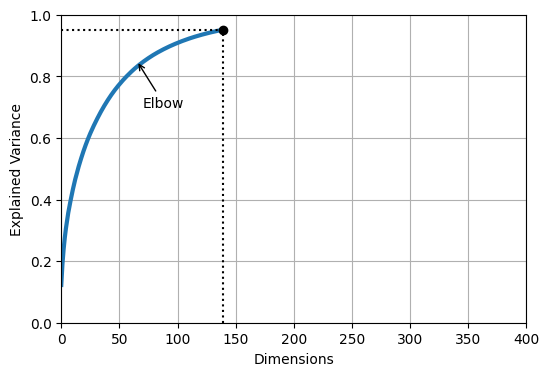

In [14]:
# Reduce features using PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_resampled)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print("New number of features / dimension size: ", d)

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [11]:
# Train model again using reduced features

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

print("Training model...")
grid_search.fit(X_train, y_train)


# Save
joblib.dump(grid_search, 'PCA_svm_model.pkl')


print("SVM with reduced features saved to PCA_svm_model.pkl")


Training model...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
SVM with reduced features saved to PCA_svm_model.pkl


In [15]:
# Evaluate model
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.4f}")

print("\nPCA SVM Performance:")
print(classification_report(y_test, y_pred))



SVM Accuracy: 0.8761

PCA SVM Performance:
              precision    recall  f1-score   support

        down       0.87      0.86      0.86       476
          go       0.89      0.87      0.88       476
        left       0.87      0.88      0.88       476
       right       0.90      0.91      0.90       476
        stop       0.90      0.90      0.90       476
          up       0.83      0.84      0.83       476

    accuracy                           0.88      2856
   macro avg       0.88      0.88      0.88      2856
weighted avg       0.88      0.88      0.88      2856



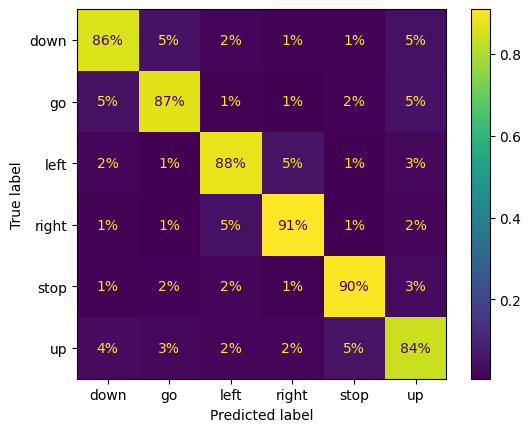

In [13]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        normalize="true", values_format=".0%")
plt.show()